In [1]:
import ee
import google.auth
import math
import numpy as np
import tensorflow as tf
import folium
import time


2023-03-23 00:02:55.631804: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# this is needed to Successfully save authorization token. from ee.Authenticate()
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [20]:
ee.Authenticate()


Successfully saved authorization token.


In [21]:
ee.Initialize()

In [5]:
# bands used for prediction
BANDS = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']

COUNTRY_GEOMETRY = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017").filter(ee.Filter.eq('country_na', 'Ukraine'));
COUNTRY_LATLON = 50., 31

LABEL_DATA = ee.ImageCollection("ESA/WorldCover/v100").first() # ee.image
LABEL_DATA = LABEL_DATA.clip(COUNTRY_GEOMETRY)


In [6]:
def mask_sentinel2_clouds(image: ee.Image) -> ee.Image:
    CLOUD_BIT = 10
    CIRRUS_CLOUD_BIT = 11
    bit_mask = (1 << CLOUD_BIT) | (1 << CIRRUS_CLOUD_BIT)
    mask = image.select("QA60").bitwiseAnd(bit_mask).eq(0)
    return image.clip(COUNTRY_GEOMETRY).updateMask(mask)
    
def get_input_image(year: int, default_value: float = 1000.0) -> ee.Image:
  return (
      ee.ImageCollection("COPERNICUS/S2_HARMONIZED")        # Sentinel-2 images
      .filterDate(f"{year}-1-1", f"{year}-12-31")           # filter by year
      .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))  # filter cloudy images 
      .map(mask_sentinel2_clouds)  # mask/hide cloudy pixels
      .select(BANDS)          # select all bands starting with B
      .median()               # median of all non-cloudy pixels
      .unmask(default_value)  # default value for masked pixels
      .float()                # convert to float32
  )

In [7]:

igbp_palette = [
    '#419BDF',  # water
    '#397D49',  # Trees
    '#88B053',  # Grass
    '#7A87C6',  # Flooded vegetation
    '#E49635',  # crops
    '#DFC35A',  # shrub and scrub
    '#C4281B',  # built-up areas
    '#A59B8F',  # bare ground
    '#B39FE1',  # snow and ice
]

LABEL_NAMES = [
  'water', 'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub',
  'built', 'bare', 'snow_and_ice'
]
map = folium.Map(location=COUNTRY_LATLON, zoom_start=13)
def get_label_image() -> ee.Image:
    # Remap the ESA classifications into the Dynamic World classifications
    fromValues = [10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100]
    toValues = [1, 5, 2, 4, 6, 7, 8, 0, 3, 3, 7]
    return (
        LABEL_DATA
        .select("Map")
        .remap(fromValues, toValues)
        .rename("landcover")
        .unmask(0)  # fill missing values with 0 (water)
        .byte()     # 9 classifications fit into an unsinged 8-bit integer
    )

image_labels = get_label_image()

vis_params = {
  "bands": ["landcover"],
  "max": len(LABEL_NAMES) - 1,
  "palette": igbp_palette,
}
mapid_labels = image_labels.getMapId(vis_params)

folium.TileLayer(
    tiles=mapid_labels['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='esa',
  ).add_to(map)


In [8]:
map

In [9]:
SURF_REF_SEN2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterDate('2020-01-01', '2020-12-31')

In [10]:
def cloudmask_surfRefSen2(image):
    opaqueClouds_mask = 1 << 10
    cirrusClouds_mask =1 << 11
    bit_mask =opaqueClouds_mask | cirrusClouds_mask
    qa = image.select('QA60')
    mask = qa.bitwiseAnd(bit_mask).eq(0)

    return image.clip(COUNTRY_GEOMETRY).updateMask(mask)

default_value = 1000.0
# ee.image.select()  supports regex
image = SURF_REF_SEN2.map(cloudmask_surfRefSen2).select(BANDS).filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20)).median().unmask(default_value).divide(10000).float()
# we divide by 10000 bc the bands are scaled by 10000 (according to https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2)


image = get_input_image(2020)

In [11]:
vis_params = {
  "min": 0,
  "max": 3000,
  "bands": ["B4", "B3", "B2"],
}

mapid = image.getMapId(vis_params)

folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite',
  ).add_to(map)

In [12]:
import geopandas as gpd

shapeFile_path = "../data/validation_data/merged_harvest_validation_20220919.shp"
shapeFile = gpd.read_file(shapeFile_path)
shapeFile[['longitude', 'latitude']] =  shapeFile[['lon', 'lat']]
lon_lat_df = shapeFile[['lon', 'lat']]
lon_lat_df = lon_lat_df.dropna()

lons_lats_np = np.array(lon_lat_df)
lons_lats_np

array([[25.45868435, 50.65504754],
       [36.2894705 , 50.29463283],
       [32.54848447, 50.8608493 ],
       ...,
       [35.05100326, 46.69351009],
       [33.66820389, 50.45192896],
       [30.63346126, 46.99444801]])

In [48]:
shapeFile

,fid,cat,id,x,y,lat,lon,strata,set,rd_id,lab_set1,val_set1,com_set1,lab_set2,val_set2,com_set2,finHarvDat,geometry,longitude,latitude
0,249.0,249.0,248.0,-321360.0,639156.0,50.655048,25.458684,20.0,free_ukraine,51.0,Shabri,1.0,Harvested 11/08/22,Josef,1.0,Harvested 05/08-11/08/22,11/08/22,POINT (2834056.683 6560486.924),25.458684,50.655048
1,165.0,165.0,164.0,447948.0,607452.0,50.294633,36.289471,20.0,free_ukraine,16.0,Shabri,0.0,Spring,Josef,0.0,NaN,NaN,POINT (4039734.283 6497444.336),36.289471,50.294633
2,400.0,400.0,399.0,179688.0,655860.0,50.860849,32.548484,20.0,free_ukraine,32.0,Shabri,2.0,"Unclear, keeps greening up and browing down",Fangjie,1.0,Harvested 31/07/2022 and 29/08/2022,NaN,POINT (3623289.622 6596702.279),32.548484,50.860849
3,387.0,387.0,386.0,115320.0,661740.0,50.928689,31.637558,20.0,free_ukraine,69.0,Shabri,0.0,Interesting,Fangjie,1.0,Harvested 17/07/2022,NaN,POINT (3521885.751 6608675.134),31.637558,50.928689
4,306.0,306.0,305.0,543120.0,393504.0,48.307964,37.348245,20.0,free_ukraine,8.0,Shabri,1.0,Harvested 23/07/22,Blake,0.0,NaN,23/07/22,POINT (4157596.478 6158229.471),37.348245,48.307964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,421.0,421.0,420.0,-101040.0,65328.0,45.578351,28.700480,21.0,free_ukraine,551.0,Saeed,2.0,unclear,No double yet,NaN,NaN,NaN,POINT (3194931.750 5713022.486),28.700480,45.578351
555,212.0,212.0,211.0,384768.0,200880.0,46.693510,35.051003,20.0,occ_ukraine,553.0,Saeed,0.0,NaN,No double yet,NaN,NaN,NaN,POINT (3901868.740 5892176.838),35.051003,46.693510
556,49.0,49.0,48.0,260640.0,613488.0,50.451929,33.668204,20.0,free_ukraine,554.0,Saeed,1.0,Harvested 300722,No double yet,NaN,NaN,30/07/22,POINT (3747936.218 6524898.988),33.668204,50.451929
557,202.0,202.0,201.0,48024.0,222684.0,46.994448,30.633461,20.0,free_ukraine,557.0,Saeed,2.0,Border,No double yet,NaN,NaN,NaN,POINT (3410110.214 5941154.836),30.633461,46.994448


In [41]:
arr = np.array(shapeFile[['com_set1']].dropna()).flatten()


In [44]:
arr = arr.astype(str)

In [47]:
np.unique(arr)

array(['01/08/22', 'Border', 'Burned 080922, but only slightly',
       'Burned 090722', 'Burned 190722 and 300722',
       'Burned 240722, unintentional and majority of field left unharvested',
       'Burnt\n150822', 'Burnt\n2208-250822', 'Burnt\n230822',
       'Burnt 07/07-09/07/22', 'Burnt 09/07/2022',
       'Burnt 09/07/22(Sorrounding region),Interesting', 'Burnt 090722',
       'Burnt 13/08/22', 'Burnt 1307-150722', 'Burnt 1407-160722',
       'Burnt 15/07/22, Shelling', 'Burnt 16/07/2022',
       'Burnt 17/07/22(Surrounding Region), Shelling, Interesting',
       'Burnt 18/07/2022', 'Burnt 30/07/22, Shelling, Interesting',
       'Burnt 300822', 'BurntPossibly 09/07/22', 'Fallow',
       'Fallow - shelled close by', 'Fallow - tilled',
       'Fallow - tilled 13/09/22', 'Fallow -tilled',
       'Field burnt but not pixel 18/08/22', 'Harvested - 07/07/22',
       'Harvested - 15/07-18/07/22', 'Harvested - 23/07/22',
       'Harvested - 29/06/22', 'Harvested 01/07-12/07/2022',
  

In [13]:
def createCoordinatesFC(lons_lats):
    """ Converts a 2-d np.array of two columns into a feature collection.

    Args:
        lons_lats (np.array): has shape (N, 2)

    Returns:
        ee.FeatureCollection
    """

    points = []
    # Create a list of ee.Geometry.Point objects from the latitudes and longitudes
    for [lon, lat] in lons_lats:
        point = ee.Geometry.Point(lon, lat)
        points.append(point)

    # Create a ee.FeatureCollection from the list of points
    return ee.FeatureCollection(points)


points_fc = createCoordinatesFC(lons_lats_np)

In [14]:
%%script echo skipping
# comment out script above to run this cell

# Overlay the points on the imagery to get training.
# Note: image_labels is an image too
training_fc = image.addBands(image_labels).sampleRegions(
  collection= points_fc,
  scale= 30
)

# Export the ee.FeatureCollection as a .GeoJSON file.
task = ee.batch.Export.table.toDrive(**{
  'collection': training_fc,
  'description':'training_data_overlayed_from_shape_file',
  'fileFormat': 'GeoJSON'
})
task.start()

while task.active():
  print('Polling for task (id: {}).'.format(task.id))
  time.sleep(5)

skipping


In [15]:
training_df = gpd.read_file("../data/training_data_overlayed_from_shape_file.geojson")
training_df.head()

,id,B1,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9,landcover,geometry
0,0_0,1361.0,1839.0,985.5,1088.5,928.0,682.0,1037.5,2267.5,2811.0,2859.0,3090.0,1009.0,4,MULTIPOINT EMPTY
1,1_0,1252.0,1952.0,1216.5,981.5,949.5,717.5,1072.0,1602.5,1834.0,1902.0,2177.0,600.0,4,MULTIPOINT EMPTY
2,2_0,1383.0,2063.0,1313.5,1108.5,900.0,932.0,1050.0,1942.0,2300.0,2385.0,2777.0,750.0,4,MULTIPOINT EMPTY
3,3_0,1404.0,1826.0,1292.0,1144.0,945.0,867.0,1086.0,1709.0,1991.0,1966.0,2248.0,616.0,4,MULTIPOINT EMPTY
4,4_0,1291.0,1521.0,1153.5,1025.0,850.5,773.0,850.0,1372.5,1576.5,1623.5,1796.5,548.0,4,MULTIPOINT EMPTY


In [16]:
#training_df = training_df.drop(["id", "geometry"], axis=1) # drop columns id, geometry

training_labels_np = (training_df[['landcover']]).to_numpy()
training_bands_np = (training_df[BANDS]).to_numpy()

print(training_bands_np.shape, training_labels_np.shape)
print(training_bands_np.dtype, training_labels_np.dtype)

(558, 12) (558, 1)
float64 int64


In [17]:
#training_labels_np = training_labels_np.astype(np.ubyte)

#training_bands_np = normalize_arr(training_bands_np)

## Below, random sample 5000 labeled points on image

In [29]:
#%%script echo skipping

sample_size = 5 * 10**3
randomized_fc = image.addBands(image_labels).sample(numPixels=sample_size, seed=42)

# Export the ee.FeatureCollection as a .GeoJSON file.
task = ee.batch.Export.table.toDrive(
  collection= randomized_fc,
  description= f'randomized_{sample_size}_points',
  fileFormat= 'GeoJSON',
  folder= 'NASA_Harvest'
)
task.start()

while task.active():
  print('time: ', (time.time()))
  time.sleep(5)

time:  1679550010.718143
time:  1679550016.022934


In [ ]:
training_df = gpd.read_file("../data/randomized_labeled_sample_from_image.geojson")
training_df.head()

In [120]:
from typing import Iterable

def sample_points(
    region: ee.Geometry, image: ee.Image, points_per_class: int, scale: int) -> Iterable[tuple[float, float]]:
    # points is FeatureCollection 
    points = image.stratifiedSample(
        points_per_class,
        region=region,
        scale=scale,
        geometries=True,
    )
    for point in points.toList(points.size()).getInfo():
        #print(point)
        yield point["geometry"]["coordinates"]

#for [lon, lat] in sample_points(countryGeometry, image_labels, points_per_class=100, scale=1000):
#    folium.Marker(location=[lat, lon], popup = str([lon, lat])).add_to(map)

for [lon, lat] in lons_lats_np:
    folium.Marker(location=[lat, lon], popup = str([lon, lat])).add_to(map)

folium.LayerControl().add_to(map)

In [121]:
map

In [122]:
import io
import requests
from google.api_core import exceptions, retry

@retry.Retry(deadline=10 * 60)  # seconds
def get_patch(image: ee.Image, lonlat: tuple[float, float], patch_size: int, scale: int) -> np.ndarray:
    point = ee.Geometry.Point(lonlat)
    url = image.getDownloadURL({
        "region": point.buffer(scale * patch_size / 2, 1).bounds(1),
        "dimensions": [patch_size, patch_size],
        "format": "NPY",
    })

    # If we get "429: Too Many Requests" errors, it's safe to retry the request.
    # The Retry library only works with `google.api_core` exceptions.
    response = requests.get(url)
    if response.status_code == 429:
        raise exceptions.TooManyRequests(response.text)

    # Still raise any other exceptions to make sure we got valid data.
    response.raise_for_status()
    return np.load(io.BytesIO(response.content), allow_pickle=True)

In [123]:
from numpy.lib.recfunctions import structured_to_unstructured

def get_input_patch(year: int, lonlat: tuple[float, float], patch_size: int) -> np.ndarray:
    image = get_input_image(year)
    patch = get_patch(image, lonlat, patch_size, scale=10)
    return structured_to_unstructured(patch)

def get_label_patch(lonlat: tuple[float, float], patch_size: int) -> np.ndarray:
    image = get_label_image()
    patch = get_patch(image, lonlat, patch_size, scale=10)
    return structured_to_unstructured(patch)

In [125]:
%%script echo skipping

def get_testing_data(lonlat: tuple[float, float], patch_size: int = 128) -> tuple[np.ndarray, np.ndarray]:
    """Gets a square around the point lonlat. This square is of length patch_size.


    Args:
        lonlat (tuple[float, float]): _description_
        patch_size (int, optional): _description_. Defaults to 128.

    Returns:
        tuple[np.ndarray, np.ndarray]: _description_
    """
    
    return (
        get_input_patch(2020, lonlat, patch_size),
        get_label_patch(lonlat, patch_size),
    )

point = (COUNTRY_LATLON[1], COUNTRY_LATLON[0]) # (lon, lat)
(testing_inputs, testing_labels) = get_testing_data(point, (512))
print(f"testing_inputs : {testing_inputs.dtype} {testing_inputs.shape}")
print(f"testing_labels : {testing_labels.dtype} {testing_labels.shape}")

skipping


In [264]:
%%script echo skipping

def serialize(inputs: np.ndarray, labels: np.ndarray) -> bytes:
    features = {
        name: tf.train.Feature(
            bytes_list=tf.train.BytesList(value=[tf.io.serialize_tensor(data).numpy()])
        )
        for name, data in {"inputs": inputs, "labels": labels}.items()
    }
    example = tf.train.Example(features=tf.train.Features(feature=features))
    return example.SerializeToString()

serialized = serialize(testing_inputs, testing_labels)
print(f"serialized: {len(serialized)} bytes")

skipping


In [225]:
def normalize_arr(arr: np.ndarray):
    newArr = arr.copy()
    mean = newArr.mean(axis=0)
    # print(mean.shape) --> (12,)
    sd = newArr.std(axis=0)
    newArr -= mean
    newArr = newArr/sd
    return newArr

In [166]:
X = np.concatenate((training_bands_np, testing_inputs[0]), axis=0)
Y = np.concatenate((training_labels_np, testing_labels[0]), axis=0)



In [153]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

training_bands_np.append(testing_inputs)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [226]:
X = testing_inputs[0]
Y = tf.keras.utils.to_categorical(testing_labels[0], num_classes=9) # convert to one hot

X = normalize_arr(X)


In [227]:
model = Sequential()
model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(9, activation='sigmoid'))
model.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 64)                832       
                                                                 
 dense_65 (Dense)            (None, 64)                4160      
                                                                 
 dense_66 (Dense)            (None, 32)                2080      
                                                                 
 dense_67 (Dense)            (None, 16)                528       
                                                                 
 dense_68 (Dense)            (None, 9)                 153       
                                                                 
Total params: 7,753
Trainable params: 7,753
Non-trainable params: 0
_________________________________________________________________


In [228]:
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['acc'])

In [229]:
model.fit(x=X, y=Y, epochs=50)

Epoch 1/50
16/16 [==============================] - 2s 11ms/step - loss: 0.6696 - acc: 0.1660
Epoch 2/50
16/16 [==============================] - 0s 5ms/step - loss: 0.6041 - acc: 0.0156
Epoch 3/50
16/16 [==============================] - 0s 5ms/step - loss: 0.5213 - acc: 0.0059
Epoch 4/50
16/16 [==============================] - 0s 3ms/step - loss: 0.3952 - acc: 0.4844
Epoch 5/50
16/16 [==============================] - 0s 4ms/step - loss: 0.1987 - acc: 0.8516
Epoch 6/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0912 - acc: 0.8770
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0744 - acc: 0.9023
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0658 - acc: 0.9004
Epoch 9/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0602 - acc: 0.9082
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0561 - acc: 0.9082
Epoch 11/50
16/16 [==============================] - 0s 3ms/step - l

In [235]:
print(model.predict(normalize_arr(training_bands_np)) [:10])

18/18 [==============================] - 0s 2ms/step
[[2.0797403e-14 1.0000000e+00 4.9819439e-14 4.4149458e-25 5.8256776e-12
  4.5273704e-19 1.8602814e-22 2.4151072e-09 2.5884039e-24]
 [2.9026800e-10 9.9999958e-01 2.6395182e-07 2.4958341e-12 3.4008187e-07
  7.0598652e-11 2.9310042e-13 2.3604119e-03 2.7550719e-14]
 [2.5544153e-07 9.9999595e-01 2.0656380e-07 8.8471954e-13 1.0616707e-06
  4.1908516e-10 8.8713125e-12 2.9404740e-05 5.7713930e-13]
 [9.9393779e-01 5.1253702e-02 1.1226284e-05 3.6245535e-07 5.8129245e-07
  9.6997137e-06 1.3749387e-07 1.2412373e-05 4.3833548e-10]
 [7.6507814e-03 8.4809321e-01 3.4071780e-07 3.5466560e-10 1.1341422e-09
  9.0489731e-09 4.8485040e-12 2.0962590e-04 1.3684637e-14]
 [7.6711600e-05 7.1283840e-03 1.4468260e-01 7.8506283e-03 9.0890253e-01
  1.4205954e-04 2.0561689e-01 9.8649738e-04 3.7409904e-05]
 [8.8222514e-06 9.9991500e-01 7.8990579e-06 7.8696510e-10 2.0745663e-05
  5.6265197e-08 3.9822261e-09 5.1350816e-04 4.0986536e-10]
 [9.2425847e-01 5.4556226e-06 

In [220]:
testing_inputs[1]

array([[1315., 1109.,  976., ...,  737., 2390., 1705.],
       [1318., 1120.,  999., ...,  724., 2490., 1794.],
       [1318., 1106., 1009., ...,  724., 2490., 1794.],
       ...,
       [1297.,  980.,  806., ...,  498., 1072.,  594.],
       [1297.,  980.,  812., ...,  498., 1403.,  754.],
       [1297.,  993.,  851., ...,  498., 1772., 1080.]], dtype=float32)

In [192]:
a = tf.keras.utils.to_categorical(Y, num_classes=9)


In [193]:
np.unique(Y)

array([0, 1, 2, 3, 4, 6, 7], dtype=uint8)

In [194]:
a.shape

(512, 9)

In [195]:
a.sum(axis=0)

array([286., 159.,   8.,  36.,  20.,   0.,   2.,   1.,   0.],
      dtype=float32)

In [221]:
training_bands_np

array([[-0.46908981, -0.69322336, -0.71213709, ...,  3.25017837,
        -1.00524363, -1.94793795],
       [-2.07328656, -1.86576377, -0.53572238, ..., -0.28971328,
        -0.6863655 , -1.26923221],
       [-0.14530698, -0.47405693, -0.94188649, ...,  1.00853549,
        -0.37313122, -0.98423457],
       ...,
       [-0.3955028 , -0.53432769,  0.25609249, ...,  0.73157576,
        -1.09836733, -0.5126663 ],
       [-0.99891626, -1.02745217, -0.74495843, ...,  0.22093124,
         0.82054532, -0.53029502],
       [ 0.03620862, -0.31077793, -0.50700371, ..., -1.38240599,
        -0.10575332,  0.44281035]])

In [239]:
np.unique(training_labels_np)

array([0, 1, 2, 4, 7])

In [255]:
onehot = tf.keras.utils.to_categorical(training_labels_np, num_classes=9).astype(int)# convert to one hot
sums = onehot.sum(axis=0)

print(list(sums))
print(LABEL_NAMES)

[2, 3, 11, 0, 541, 0, 0, 1, 0]
['water', 'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub', 'built', 'bare', 'snow_and_ice']


In [256]:
training_df

,id,B1,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9,landcover,geometry
0,0_0,1361.0000,1839.0000,985.5,1088.50,928.0,682.0,1037.5,2267.5000,2811.0000,2859.0000,3090.0,1009.0000,4,MULTIPOINT EMPTY
1,1_0,1252.0000,1952.0000,1216.5,981.50,949.5,717.5,1072.0,1602.5000,1834.0000,1902.0000,2177.0,600.0000,4,MULTIPOINT EMPTY
2,2_0,1383.0000,2063.0000,1313.5,1108.50,900.0,932.0,1050.0,1942.0000,2300.0000,2385.0000,2777.0,750.0000,4,MULTIPOINT EMPTY
3,3_0,1404.0000,1826.0000,1292.0,1144.00,945.0,867.0,1086.0,1709.0000,1991.0000,1966.0000,2248.0,616.0000,4,MULTIPOINT EMPTY
4,4_0,1291.0000,1521.0000,1153.5,1025.00,850.5,773.0,850.0,1372.5000,1576.5000,1623.5000,1796.5,548.0000,4,MULTIPOINT EMPTY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553,553_0,1386.0000,2382.6667,1717.0,1134.75,1007.0,1012.0,1198.0,1619.4286,1834.6000,1840.1428,2060.2,747.3333,4,MULTIPOINT EMPTY
554,554_0,1370.0000,2578.5000,2120.0,1155.00,1035.0,1112.0,1200.0,1581.5000,1768.0000,1770.0000,1962.0,546.0000,4,MULTIPOINT EMPTY
555,555_0,1366.0000,1806.0000,1474.0,1103.00,1046.0,1036.0,1178.0,2154.0000,2390.0000,2596.0000,2705.0,718.0000,4,MULTIPOINT EMPTY
556,556_0,1325.0000,2486.0000,1468.0,1058.00,924.0,902.0,1050.0,1900.0000,2234.0000,2286.0000,2668.0,659.0000,4,MULTIPOINT EMPTY


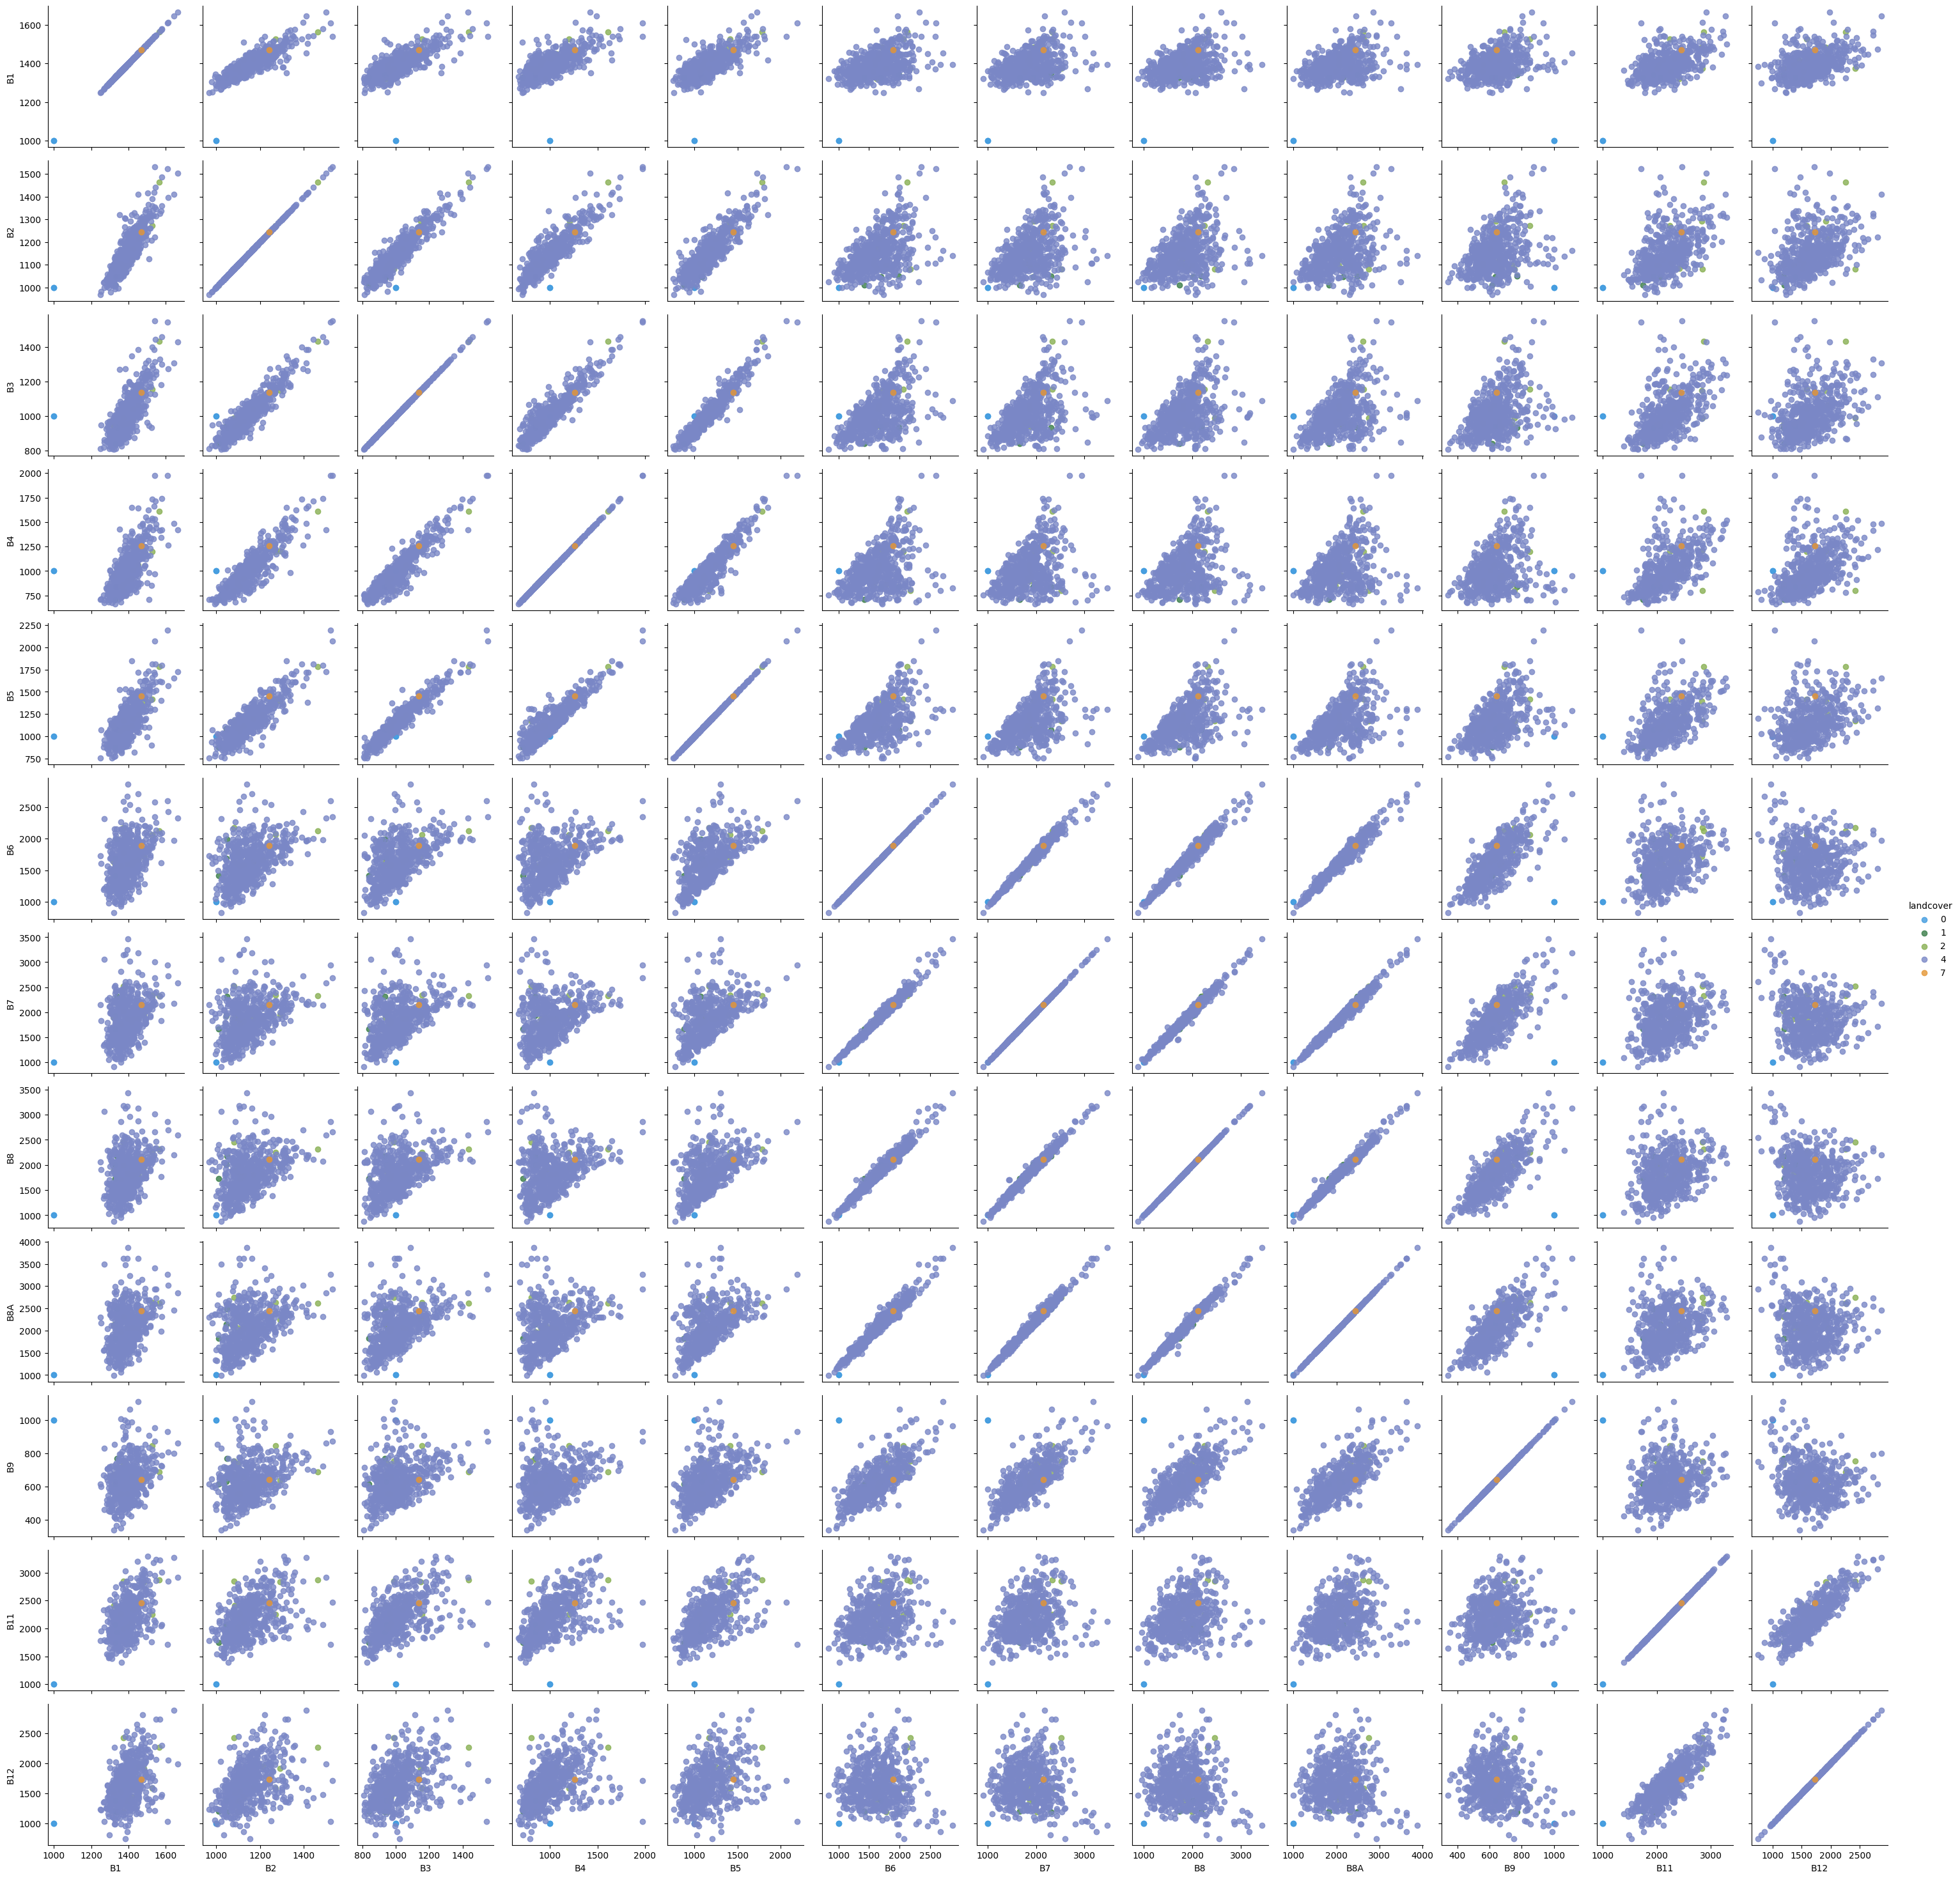

In [260]:
import seaborn as sns
import matplotlib.pyplot as plt

data= training_df

g = sns.PairGrid(data, vars=BANDS,
                 hue='landcover', palette=igbp_palette)
g.map(plt.scatter, alpha=0.8)
g.add_legend();

In [263]:
g = sns.PairGrid(iris, hue="species")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

,id,B1,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9,landcover,geometry
0,0_0,1361.0,1839.0,985.5,1088.5,928.0,682.0,1037.5,2267.5,2811.0,2859.0,3090.0,1009.0,4,MULTIPOINT EMPTY
1,1_0,1252.0,1952.0,1216.5,981.5,949.5,717.5,1072.0,1602.5,1834.0,1902.0,2177.0,600.0,4,MULTIPOINT EMPTY
2,2_0,1383.0,2063.0,1313.5,1108.5,900.0,932.0,1050.0,1942.0,2300.0,2385.0,2777.0,750.0,4,MULTIPOINT EMPTY
3,3_0,1404.0,1826.0,1292.0,1144.0,945.0,867.0,1086.0,1709.0,1991.0,1966.0,2248.0,616.0,4,MULTIPOINT EMPTY
4,4_0,1291.0,1521.0,1153.5,1025.0,850.5,773.0,850.0,1372.5,1576.5,1623.5,1796.5,548.0,4,MULTIPOINT EMPTY
